# JAXSR: Comprehensive Tutorial

This notebook provides a comprehensive introduction to JAXSR, a JAX-based symbolic regression library.

## Table of Contents
1. [Installation & Setup](#1-installation--setup)
2. [Basic Usage](#2-basic-usage)
3. [Building Basis Libraries](#3-building-basis-libraries)
4. [Selection Strategies](#4-selection-strategies)
5. [Regularization](#5-regularization)
6. [Physical Constraints](#6-physical-constraints)
7. [Custom Nonlinear Constraints](#7-custom-nonlinear-constraints)
8. [Adaptive Sampling](#8-adaptive-sampling)
9. [Model Export & Visualization](#9-model-export--visualization)
10. [Advanced: Chemical Kinetics](#10-advanced-chemical-kinetics)
11. [Advanced: Heat Transfer Correlations](#11-advanced-heat-transfer-correlations)
12. [Uncertainty Quantification](#12-uncertainty-quantification)

## 1. Installation & Setup

In [1]:
# Install jaxsr (uncomment if needed)
# !pip install jaxsr

import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

print("Setup complete!")

Setup complete!


## 2. Basic Usage

Let's start with a simple example — discovering the true model:

$$y = 2.5\,x_1 + 1.2\,x_1 x_2 - 0.8\,x_2^2$$

In [2]:
from jaxsr import BasisLibrary, SymbolicRegressor

# Generate synthetic data
n_samples = 200
X = np.random.randn(n_samples, 2) * 2
y_true = 2.5 * X[:, 0] + 1.2 * X[:, 0] * X[:, 1] - 0.8 * X[:, 1]**2
y = y_true + np.random.randn(n_samples) * 0.1  # Add noise

X_jax = jnp.array(X)
y_jax = jnp.array(y)

print("True model: y = 2.5*x + 1.2*x*y - 0.8*y^2")
print(f"Data shape: X={X.shape}, y={y.shape}")

True model: y = 2.5*x + 1.2*x*y - 0.8*y^2
Data shape: X=(200, 2), y=(200,)


In [3]:
# Build a basis library
library = (BasisLibrary(n_features=2, feature_names=["x", "y"])
    .add_constant()
    .add_linear()
    .add_polynomials(max_degree=3)
    .add_interactions(max_order=2)
)

print(f"Library contains {len(library)} basis functions:")
print(library.names)

Library contains 8 basis functions:
['1', 'x', 'y', 'x^2', 'x^3', 'y^2', 'y^3', 'x*y']


In [4]:
# Fit the model
model = SymbolicRegressor(
    basis_library=library,
    max_terms=5,
    strategy="greedy_forward",
    information_criterion="bic",
)
model.fit(X_jax, y_jax)

# Results
print("\n" + "="*60)
print("RESULTS")
print("="*60)
print(f"\nDiscovered: {model.expression_}")
print(f"\nR² = {model.metrics_['r2']:.6f}")
print(f"MSE = {model.metrics_['mse']:.6f}")
print(f"BIC = {model.metrics_['bic']:.2f}")
print(f"Complexity = {model.complexity_}")


RESULTS

Discovered: y = - 0.7996*y^2 + 2.502*x + 1.198*x*y - 0.002767*x^2

R² = 0.999827
MSE = 0.009535
BIC = -341.78
Complexity = 7


Parameter Significance (95% CI):
             Term   Estimate   Std Err        t    p-value 95% CI
  ---------------------------------------------------------------------------
              y^2    -0.7996    0.0010  -780.22   0.00e+00 [-0.8017, -0.7976] ***
                x     2.5023    0.0037   672.60   0.00e+00 [2.4950, 2.5096] ***
              x*y     1.1983    0.0020   604.49   0.00e+00 [1.1944, 1.2022] ***
              x^2    -0.0028    0.0011    -2.50   1.33e-02 [-0.0049, -0.0006] *
  --- *** p<0.001, ** p<0.01, * p<0.05


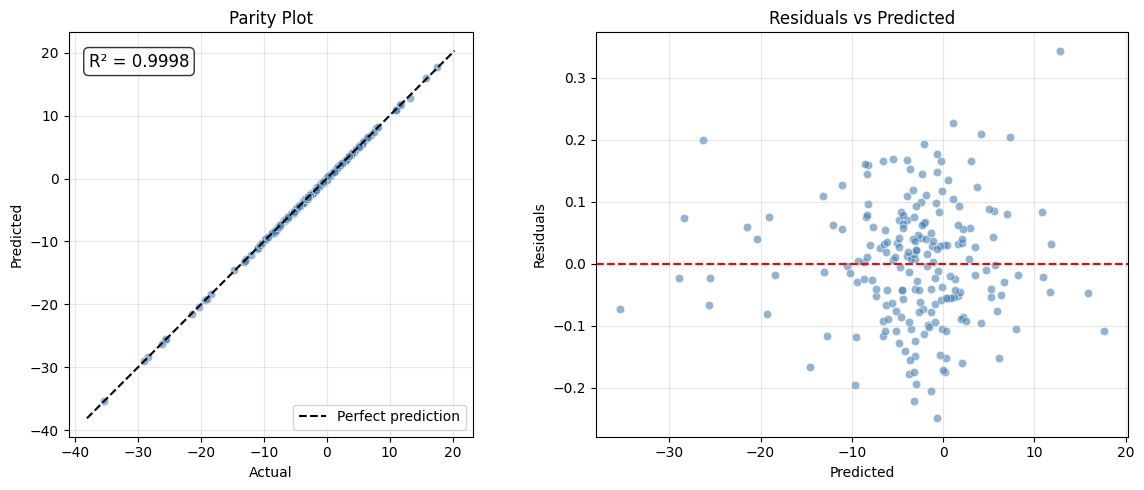

In [5]:
# Parameter significance and diagnostic plots
from scipy import stats as sp_stats

from jaxsr.plotting import plot_parity

intervals = model.coefficient_intervals(alpha=0.05)
n, k = len(y_jax), len(model.selected_features_)
df = n - k

print("Parameter Significance (95% CI):")
print(f"  {'Term':>15s} {'Estimate':>10s} {'Std Err':>9s} {'t':>8s} {'p-value':>10s} 95% CI")
print("  " + "-" * 75)
for name, (est, lo, hi, se) in intervals.items():
    t_val = est / se if abs(se) > 1e-15 else float("inf")
    p_val = float(2 * (1 - sp_stats.t.cdf(abs(t_val), df))) if df > 0 else 0.0
    sig = "***" if p_val < 0.001 else ("**" if p_val < 0.01 else ("*" if p_val < 0.05 else ""))
    print(f"  {name:>15s} {est:10.4f} {se:9.4f} {t_val:8.2f} {p_val:10.2e} [{lo:.4f}, {hi:.4f}] {sig}")
print("  --- *** p<0.001, ** p<0.01, * p<0.05")

# Parity and residual plots
y_pred = model.predict(X_jax)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_parity(y_jax, y_pred, ax=axes[0], title="Parity Plot")
residuals = np.array(y_jax - y_pred)
axes[1].scatter(np.array(y_pred), residuals, alpha=0.6, c="steelblue", edgecolors="white", linewidth=0.5)
axes[1].axhline(y=0, color="r", linestyle="--")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Residuals vs Predicted")
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [6]:
# ANOVA table for basic usage fit
from jaxsr import anova

anova_result = anova(model)
summary_sources = {"Model", "Residual", "Total"}

print("ANOVA Table (Basic Usage)")
print("=" * 80)
print(f"  {'Source':25s}  {'DF':>4}  {'Sum Sq':>12}  {'Mean Sq':>12}  {'F':>10}  {'p-value':>10}")
print("-" * 80)
for row in anova_result.rows:
    f_str = f"{row.f_value:10.2f}" if row.f_value is not None else "          "
    p_str = f"{row.p_value:10.4f}" if row.p_value is not None else "          "
    print(f"  {row.source:25s}  {row.df:4d}  {row.sum_sq:12.4f}  {row.mean_sq:12.4f}  {f_str}  {p_str}")
print("-" * 80)

# Percent variance contributions (model terms only)
term_rows = [r for r in anova_result.rows if r.source not in summary_sources]
if term_rows:
    model_ss = sum(r.sum_sq for r in term_rows)
    print("\nVariance Contributions:")
    for row in term_rows:
        pct = 100 * row.sum_sq / model_ss if model_ss > 0 else 0
        sig = (
            "***" if row.p_value is not None and row.p_value < 0.001 else (
            "**" if row.p_value is not None and row.p_value < 0.01 else (
            "*" if row.p_value is not None and row.p_value < 0.05 else ""))
        )
        print(f"  {row.source:25s}  {pct:6.1f}%  {sig}")

ANOVA Table (Basic Usage)
  Source                       DF        Sum Sq       Mean Sq           F     p-value
--------------------------------------------------------------------------------
  y^2                           1     4102.7339     4102.7339   421667.93      0.0000
  x                             1     3311.9346     3311.9346   340391.70      0.0000
  x*y                           1     3577.5786     3577.5786   367693.88      0.0000
  x^2                           1        0.0608        0.0608        6.25      0.0133
  Model                         3    10992.3078     3664.1026   376586.59      0.0000
  Residual                    196        1.9070        0.0097                        
  Total                       199    10994.2148       55.2473                        
--------------------------------------------------------------------------------

Variance Contributions:
  y^2                          37.3%  ***
  x                            30.1%  ***
  x*y          

In [7]:
# Quick fitting with convenience function
from jaxsr import fit_symbolic

model_quick = fit_symbolic(
    X_jax, y_jax,
    feature_names=["x", "y"],
    max_terms=5,
    max_poly_degree=3,
)

print(f"Quick fit result: {model_quick.expression_}")

/Users/jkitchin/Dropbox/projects/jaxsr/src/jaxsr/regressor.py:1234: UserWarning: Removing 4 basis functions with non-finite values
  return model.fit(X, y)


Quick fit result: y = - 0.7996*y^2 + 2.502*x + 1.198*x*y - 0.002767*x^2


## 3. Building Basis Libraries

JAXSR provides flexible ways to build basis libraries with different types of functions.

In [8]:
# Comprehensive library with all function types
comprehensive_library = (BasisLibrary(n_features=2, feature_names=["T", "P"])
    .add_constant()                           # 1
    .add_linear()                             # T, P
    .add_polynomials(max_degree=3)            # T^2, T^3, P^2, P^3
    .add_interactions(max_order=2)            # T*P
    .add_transcendental(["log", "exp", "sqrt", "inv"])  # log(T), exp(T), etc.
    .add_ratios()                             # T/P, P/T
)

print(f"Comprehensive library: {len(comprehensive_library)} functions")
print("\nFunctions:")
for i, name in enumerate(comprehensive_library.names):
    print(f"  [{i:2d}] {name}")

Comprehensive library: 18 functions

Functions:
  [ 0] 1
  [ 1] T
  [ 2] P
  [ 3] T^2
  [ 4] T^3
  [ 5] P^2
  [ 6] P^3
  [ 7] T*P
  [ 8] log(T)
  [ 9] exp(T)
  [10] sqrt(T)
  [11] 1/T
  [12] log(P)
  [13] exp(P)
  [14] sqrt(P)
  [15] 1/P
  [16] T/P
  [17] P/T


In [9]:
# Custom basis functions
custom_library = (BasisLibrary(n_features=2, feature_names=["C_A", "C_B"])
    .add_constant()
    .add_linear()
    .add_custom(
        name="C_A*C_B/(1+C_A)",
        func=lambda X: X[:, 0] * X[:, 1] / (1 + X[:, 0]),
        complexity=4,
    )
    .add_custom(
        name="Arrhenius",
        func=lambda X: jnp.exp(-X[:, 0] / (X[:, 1] + 1e-6)),
        complexity=3,
    )
)

print(f"Custom library: {custom_library.names}")

Custom library: ['1', 'C_A', 'C_B', 'C_A*C_B/(1+C_A)', 'Arrhenius']


In [10]:
# Advanced: Compositions and Rational Forms
advanced_library = (BasisLibrary(n_features=2, feature_names=["x", "y"])
    .add_constant()
    .add_linear()
    .add_compositions(["log", "exp"], ["product", "ratio"])  # log(x*y), exp(x/y)
    .add_rational_forms()  # x/(1+x), x*y/(1+x+y)
    .add_power_laws([0.5, 0.33, 0.67])  # x^0.5, x^(1/3), etc.
)

print(f"Advanced library: {len(advanced_library)} functions")
print("\nSample functions:")
for name in advanced_library.names[:15]:
    print(f"  {name}")
if len(advanced_library.names) > 15:
    print("  ...")

Advanced library: 25 functions

Sample functions:
  1
  x
  y
  log(x*y)
  log(x/y)
  exp(x*y)
  exp(x/y)
  log(y/x)
  exp(y/x)
  x/(1+x)
  x/(1+x)^2
  y/(1+y)
  y/(1+y)^2
  x*y/(1+x)
  x*y/(1+x+y)
  ...


## 4. Selection Strategies

JAXSR supports multiple strategies for selecting the best subset of basis functions.

In [11]:
# Generate test data
np.random.seed(42)
X_test = np.random.randn(100, 2)
y_test = 2.0 * X_test[:, 0] - 0.5 * X_test[:, 1]**2 + 1.0

library = (BasisLibrary(n_features=2, feature_names=["x", "y"])
    .add_constant()
    .add_linear()
    .add_polynomials(max_degree=3)
    .add_interactions()
)

X_jax = jnp.array(X_test)
y_jax = jnp.array(y_test)

In [12]:
# Compare different strategies
strategies = ["greedy_forward", "exhaustive"]
results = {}

for strategy in strategies:
    model = SymbolicRegressor(
        basis_library=library,
        max_terms=4,
        strategy=strategy,
    )
    model.fit(X_jax, y_jax)
    results[strategy] = model
    print(f"\n{strategy}:")
    print(f"  Expression: {model.expression_}")
    print(f"  R² = {model.score(X_jax, y_jax):.6f}")
    print(f"  BIC = {model.metrics_['bic']:.2f}")


greedy_forward:
  Expression: y = 2*x + 1 - 0.5*y^2 - 3.5612e-08*y
  R² = 1.000000
  BIC = -2622.28

exhaustive:
  Expression: y = 1 + 2*x - 0.5*y^2


  R² = 1.000000
  BIC = -2583.36


In [13]:
# Explore the Pareto front (complexity vs accuracy tradeoff)
model = results["greedy_forward"]

print("Pareto Front (Complexity vs MSE):")
print("-" * 60)
for result in model.pareto_front_:
    print(f"Complexity {result.complexity:2d} | MSE {result.mse:.6f}")
    print(f"  {result.expression()}")
    print()

Pareto Front (Complexity vs MSE):
------------------------------------------------------------
Complexity  1 | MSE 0.443272
  y = 1.904*x + 0.4944

Complexity  3 | MSE 0.000000
  y = 2*x + 1 - 0.5*y^2

Complexity  4 | MSE 0.000000
  y = 2*x + 1 - 0.5*y^2 - 3.5612e-08*y



## 5. Regularization

JAXSR supports L2 (ridge) regularization to prevent overfitting and control coefficient magnitudes.

In [14]:
# Generate noisy data with many potential features
np.random.seed(42)
X_reg = np.random.randn(50, 2)
y_reg = 2.0 * X_reg[:, 0] + 0.5 * X_reg[:, 1] + np.random.randn(50) * 0.5  # More noise

library_large = (BasisLibrary(n_features=2, feature_names=["x", "y"])
    .add_constant()
    .add_linear()
    .add_polynomials(max_degree=4)
    .add_interactions()
)

print(f"Library size: {len(library_large)} functions")

Library size: 10 functions


In [15]:
# Fit without regularization
model_unreg = SymbolicRegressor(
    basis_library=library_large,
    max_terms=5,
    regularization=None,  # No regularization
)
model_unreg.fit(jnp.array(X_reg), jnp.array(y_reg))

print("Without regularization:")
print(f"  Expression: {model_unreg.expression_}")
print(f"  Coefficients: {[float(c) for c in model_unreg.coefficients_]}")

Without regularization:
  Expression: y = 1.943*x + 0.4763*y
  Coefficients: [1.942753553390503, 0.47629597783088684]


## 6. Physical Constraints

Incorporate domain knowledge through physical constraints. Here we model a reaction rate with the true form:

$$r = 2\sqrt{C}$$

## 6. Physical Constraints

Incorporate domain knowledge through physical constraints.

In [16]:
from jaxsr import Constraints

# Example: Reaction rate must be non-negative
# and should increase with concentration

# Generate data for a reaction rate
np.random.seed(42)
C = np.random.uniform(0.1, 2.0, 100)
rate = 2.0 * C**0.5  # True: r = 2*sqrt(C)
rate += np.random.randn(100) * 0.05

X = jnp.array(C.reshape(-1, 1))
y = jnp.array(rate)

In [17]:
# Build library
library = (BasisLibrary(n_features=1, feature_names=["C"])
    .add_constant()
    .add_linear()
    .add_polynomials(max_degree=2)
    .add_transcendental(["sqrt", "log"])
)

# Add constraints
constraints = (Constraints()
    .add_bounds("y", lower=0)  # Rate >= 0
    .add_sign_constraint("C", sign="positive")  # Positive coefficient
)

# Fit with constraints
model = SymbolicRegressor(
    basis_library=library,
    max_terms=3,
    constraints=constraints,
)
model.fit(X, y)

print(f"Discovered: {model.expression_}")
print(f"R² = {model.score(X, y):.4f}")
print("\nTrue model: r = 2.0*sqrt(C)")

Discovered: y = 1.997*sqrt(C)
R² = 0.9944

True model: r = 2.0*sqrt(C)


In [18]:
# ANOVA table for constrained fit
anova_result = anova(model)
summary_sources = {"Model", "Residual", "Total"}

print("ANOVA Table (Constrained Fit)")
print("=" * 80)
print(f"  {'Source':25s}  {'DF':>4}  {'Sum Sq':>12}  {'Mean Sq':>12}  {'F':>10}  {'p-value':>10}")
print("-" * 80)
for row in anova_result.rows:
    f_str = f"{row.f_value:10.2f}" if row.f_value is not None else "          "
    p_str = f"{row.p_value:10.4f}" if row.p_value is not None else "          "
    print(f"  {row.source:25s}  {row.df:4d}  {row.sum_sq:12.4f}  {row.mean_sq:12.4f}  {f_str}  {p_str}")
print("-" * 80)

term_rows = [r for r in anova_result.rows if r.source not in summary_sources]
if term_rows:
    model_ss = sum(r.sum_sq for r in term_rows)
    print("\nVariance Contributions:")
    for row in term_rows:
        pct = 100 * row.sum_sq / model_ss if model_ss > 0 else 0
        sig = (
            "***" if row.p_value is not None and row.p_value < 0.001 else (
            "**" if row.p_value is not None and row.p_value < 0.01 else (
            "*" if row.p_value is not None and row.p_value < 0.05 else ""))
        )
        print(f"  {row.source:25s}  {pct:6.1f}%  {sig}")

ANOVA Table (Constrained Fit)
  Source                       DF        Sum Sq       Mean Sq           F     p-value
--------------------------------------------------------------------------------
  sqrt(C)                       1       36.5880       36.5880    17614.16      0.0000
  Model                         1       36.5880       36.5880    17614.16      0.0000
  Residual                     99        0.2056        0.0021                        
  Total                        99       36.7937        0.3717                        
--------------------------------------------------------------------------------

Variance Contributions:
  sqrt(C)                     100.0%  ***


Parameter Significance (Constrained Fit):
             Term   Estimate   Std Err        t    p-value 95% CI
  ---------------------------------------------------------------------------
          sqrt(C)     1.9975    0.0046   436.81   0.00e+00 [1.9884, 2.0065] ***
  --- *** p<0.001, ** p<0.01, * p<0.05


/var/folders/gq/k1kgbl7n539_4dl1md8x3jt80000gn/T/ipykernel_61762/2065125682.py:4: UserWarning: Constraints are active. Classical OLS intervals may not be valid. Consider using bootstrap methods instead.
  intervals = model.coefficient_intervals(alpha=0.05)


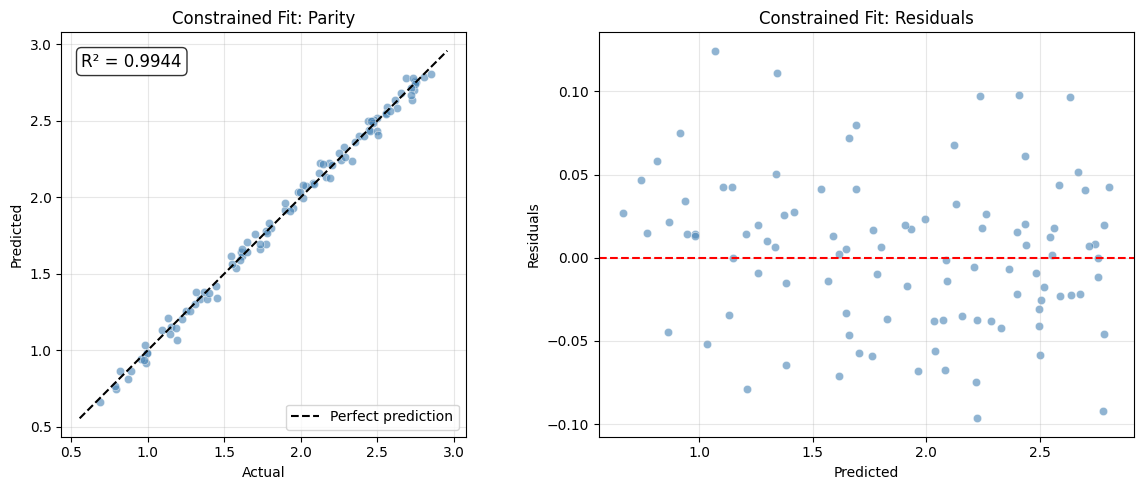

In [19]:
# Parameter significance and diagnostics for constrained fit
from jaxsr.plotting import plot_parity

intervals = model.coefficient_intervals(alpha=0.05)
n_obs, k_terms = len(np.asarray(y)), len(model.selected_features_)
df_resid = n_obs - k_terms

print("Parameter Significance (Constrained Fit):")
print(f"  {'Term':>15s} {'Estimate':>10s} {'Std Err':>9s} {'t':>8s} {'p-value':>10s} 95% CI")
print("  " + "-" * 75)
for name, (est, lo, hi, se) in intervals.items():
    t_val = est / se if abs(se) > 1e-15 else float("inf")
    p_val = float(2 * (1 - sp_stats.t.cdf(abs(t_val), df_resid))) if df_resid > 0 else 0.0
    sig = "***" if p_val < 0.001 else ("**" if p_val < 0.01 else ("*" if p_val < 0.05 else ""))
    print(f"  {name:>15s} {est:10.4f} {se:9.4f} {t_val:8.2f} {p_val:10.2e} [{lo:.4f}, {hi:.4f}] {sig}")
print("  --- *** p<0.001, ** p<0.01, * p<0.05")

# Parity and residual plots
y_pred = model.predict(X)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_parity(y, y_pred, ax=axes[0], title="Constrained Fit: Parity")
residuals = np.array(y - y_pred)
axes[1].scatter(np.array(y_pred), residuals, alpha=0.6, c="steelblue", edgecolors="white", linewidth=0.5)
axes[1].axhline(y=0, color="r", linestyle="--")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Constrained Fit: Residuals")
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [20]:
# Fixed coefficient example: known intercept
constraints_fixed = (Constraints()
    .add_known_coefficient("1", value=0.0, fixed=True)  # No intercept
)

model_fixed = SymbolicRegressor(
    basis_library=library,
    max_terms=2,
    constraints=constraints_fixed,
)
model_fixed.fit(X, y)

print(f"With fixed intercept=0: {model_fixed.expression_}")

With fixed intercept=0: y = 1.997*sqrt(C)


## 7. Custom Nonlinear Constraints

JAXSR supports arbitrary nonlinear constraints through callback functions.

In [21]:
# Example: Constraint that sum of coefficients should be approximately 2.5
def sum_constraint(coeffs, X, y_pred):
    """Penalize if sum of coefficients deviates from 2.5"""
    target_sum = 2.5
    return float((jnp.sum(coeffs) - target_sum) ** 2)

# Create constraint
custom_constraints = (Constraints()
    .add_custom("sum_equals_2.5", sum_constraint, weight=1.0)
)

print("Created custom constraint: sum of coefficients ≈ 2.5")

Created custom constraint: sum of coefficients ≈ 2.5


In [22]:
# Fit with custom constraint
library_simple = (BasisLibrary(n_features=2, feature_names=["x", "y"])
    .add_constant()
    .add_linear()
    .add_polynomials(max_degree=2)
)

np.random.seed(42)
X_custom = np.random.randn(100, 2)
y_custom = 1.5 * X_custom[:, 0] + 0.8 * X_custom[:, 1] + np.random.randn(100) * 0.1

model_custom = SymbolicRegressor(
    basis_library=library_simple,
    max_terms=3,
    constraints=custom_constraints,
)
model_custom.fit(jnp.array(X_custom), jnp.array(y_custom))

print(f"Expression: {model_custom.expression_}")
print(f"Coefficient sum: {float(jnp.sum(model_custom.coefficients_)):.4f} (target: 2.5)")

Expression: y = 1.518*x + 0.7831*y
Coefficient sum: 2.3008 (target: 2.5)


In [23]:
# Physics constraint: model should pass through a specific point
passthrough_constraints = (Constraints()
    .add_physics_constraint(
        "origin", "passthrough",
        {"point": [0.0, 0.0], "value": 0.0},
        weight=10.0
    )
)

print("Created passthrough constraint: f(0, 0) ≈ 0")

Created passthrough constraint: f(0, 0) ≈ 0


## 8. Adaptive Sampling

Iteratively improve models by suggesting new data points to query.

In [24]:
from jaxsr import AdaptiveSampler

# Initial data (sparse)
np.random.seed(42)
X_init = np.random.uniform(0, 5, (20, 2))
y_init = X_init[:, 0]**2 + 2*X_init[:, 1]  # True: y = x^2 + 2y

library = (BasisLibrary(n_features=2, feature_names=["x", "y"])
    .add_constant()
    .add_linear()
    .add_polynomials(max_degree=3)
)

# Initial fit
model = SymbolicRegressor(basis_library=library, max_terms=4)
model.fit(jnp.array(X_init), jnp.array(y_init))

print(f"Initial model: {model.expression_}")
print(f"Initial R² = {model.score(jnp.array(X_init), jnp.array(y_init)):.4f}")

Initial model: y = 1.838*x + 0.1027*y^2 + 0.1398*x^3 + 1.417*y
Initial R² = 0.9969


In [25]:
# Create sampler
sampler = AdaptiveSampler(
    model=model,
    bounds=[(0, 5), (0, 5)],
    strategy="space_filling",
)

# Suggest new points
result = sampler.suggest(n_points=10)
X_new = np.array(result.points)

print(f"\nSuggested {len(X_new)} new points:")
for i, point in enumerate(X_new[:5]):
    print(f"  Point {i+1}: x={point[0]:.2f}, y={point[1]:.2f}")
print("  ...")


Suggested 10 new points:
  Point 1: x=4.83, y=2.16
  Point 2: x=3.18, y=4.87
  Point 3: x=4.87, y=2.19
  Point 4: x=3.35, y=4.84
  Point 5: x=3.82, y=4.95
  ...


In [26]:
# Simulate querying the "oracle" (in practice, run experiments)
y_new = X_new[:, 0]**2 + 2*X_new[:, 1]

# Update model with new data
model.update(jnp.array(X_new), jnp.array(y_new), refit=True)

print(f"\nUpdated model: {model.expression_}")
X_all = np.vstack([X_init, X_new])
y_all = np.concatenate([y_init, y_new])
print(f"Updated R² = {model.score(jnp.array(X_all), jnp.array(y_all)):.4f}")


Updated model: y = 2.163*x + 0.8096*y^2 + 0.1269*x^3 - 0.0889*y^3
Updated R² = 0.9984


## 9. Model Export & Visualization

In [27]:
# Fit a model
np.random.seed(42)
X = np.random.randn(100, 2)
y = 2.0 * X[:, 0] + X[:, 1]**2 - 0.5

model = fit_symbolic(
    jnp.array(X), jnp.array(y),
    feature_names=["a", "b"],
    max_terms=4,
)

print(f"Expression: {model.expression_}")

Expression: y = 2*a + b^2 - 0.5 - 7.8165e-08*log(a)


/Users/jkitchin/Dropbox/projects/jaxsr/src/jaxsr/regressor.py:1234: UserWarning: Removing 4 basis functions with non-finite values
  return model.fit(X, y)


In [28]:
# Export to SymPy
try:
    sympy_expr = model.to_sympy()
    print(f"SymPy: {sympy_expr}")

    # LaTeX export
    latex = model.to_latex()
    print(f"LaTeX: {latex}")
except ImportError:
    print("SymPy not available")

SymPy: 1.99999964237213*a + 0.999999761581421*b**2.0 - 7.81645397296415e-8*log(a) - 0.499999672174454
LaTeX: 1.99999964237213 a + 0.999999761581421 b^{2.0} - 7.81645397296415 \cdot 10^{-8} \log{\left(a \right)} - 0.499999672174454


In [29]:
# Export to pure NumPy callable (no JAX dependency)
predict_fn = model.to_callable()

# Use with pure NumPy
X_numpy = np.array([[1.0, 2.0], [3.0, 4.0]])
y_pred = predict_fn(X_numpy)

print(f"NumPy predictions: {y_pred}")

NumPy predictions: [ 5.49999902 21.49999535]


## 10. Advanced: Chemical Kinetics

Discover rate laws from kinetic data. The true model follows Langmuir–Hinshelwood kinetics:

$$r = \frac{k\,C_A\,C_B}{1 + K\,C_A}, \quad k = 2.5,\; K = 1.2$$

In [30]:
# Save and load model
model.save("my_model.json")
loaded_model = SymbolicRegressor.load("my_model.json")

print(f"Loaded model: {loaded_model.expression_}")

# Clean up
import os

os.remove("my_model.json")

Loaded model: y = 2*a + b^2 - 0.5 - 7.8165e-08*log(a)


## 10. Advanced: Chemical Kinetics

Discover rate laws from kinetic data.

In [31]:
# Generate Langmuir-Hinshelwood kinetics data
# True: r = k * C_A * C_B / (1 + K * C_A)

np.random.seed(42)
n_samples = 100

C_A = np.random.uniform(0.1, 2.0, n_samples)
C_B = np.random.uniform(0.1, 2.0, n_samples)

k, K = 2.5, 1.2
r_true = k * C_A * C_B / (1 + K * C_A)
r = r_true + np.random.randn(n_samples) * 0.03

X = jnp.column_stack([C_A, C_B])
y = jnp.array(r)

print("True model: r = 2.5*C_A*C_B / (1 + 1.2*C_A)")

True model: r = 2.5*C_A*C_B / (1 + 1.2*C_A)


In [32]:
# Build kinetics-appropriate library
kinetics_library = (BasisLibrary(n_features=2, feature_names=["C_A", "C_B"])
    .add_constant()
    .add_linear()
    .add_interactions(max_order=2)
    .add_rational_forms()  # Langmuir-type terms
    .add_ratios()
)

print(f"Kinetics library: {len(kinetics_library)} functions")

Kinetics library: 16 functions


## 11. Advanced: Heat Transfer Correlations

Discover empirical correlations like the Dittus–Boelter equation:

$$\mathrm{Nu} = 0.023\,\mathrm{Re}^{0.8}\,\mathrm{Pr}^{0.4}$$

In [33]:
# Fit with constraint: rate must be non-negative
constraints = Constraints().add_bounds("y", lower=0)

model = SymbolicRegressor(
    basis_library=kinetics_library,
    max_terms=5,
    strategy="greedy_forward",
    constraints=constraints,
)
model.fit(X, y)

print(f"\nDiscovered: {model.expression_}")
print(f"R² = {model.metrics_['r2']:.4f}")
print("\nTrue: r = 2.5*C_A*C_B / (1 + 1.2*C_A)")


Discovered: y = 2.581*C_A*C_B/(1+C_A) - 0.09397*C_A*C_B - 0.1658*C_A*C_B/(1+C_A+C_B)
R² = 0.9982

True: r = 2.5*C_A*C_B / (1 + 1.2*C_A)


Parameter Significance (Kinetics Fit):
                       Term   Estimate   Std Err        t    p-value 95% CI
  -------------------------------------------------------------------------------------
            C_A*C_B/(1+C_A)     2.5815    0.0353    73.11   0.00e+00 [2.5114, 2.6515] ***
                    C_A*C_B    -0.0940    0.0143    -6.55   2.72e-09 [-0.1224, -0.0655] ***
        C_A*C_B/(1+C_A+C_B)    -0.1658    0.0730    -2.27   2.53e-02 [-0.3106, -0.0210] *
  --- *** p<0.001, ** p<0.01, * p<0.05


/var/folders/gq/k1kgbl7n539_4dl1md8x3jt80000gn/T/ipykernel_61762/1242658653.py:2: UserWarning: Constraints are active. Classical OLS intervals may not be valid. Consider using bootstrap methods instead.
  intervals = model.coefficient_intervals(alpha=0.05)


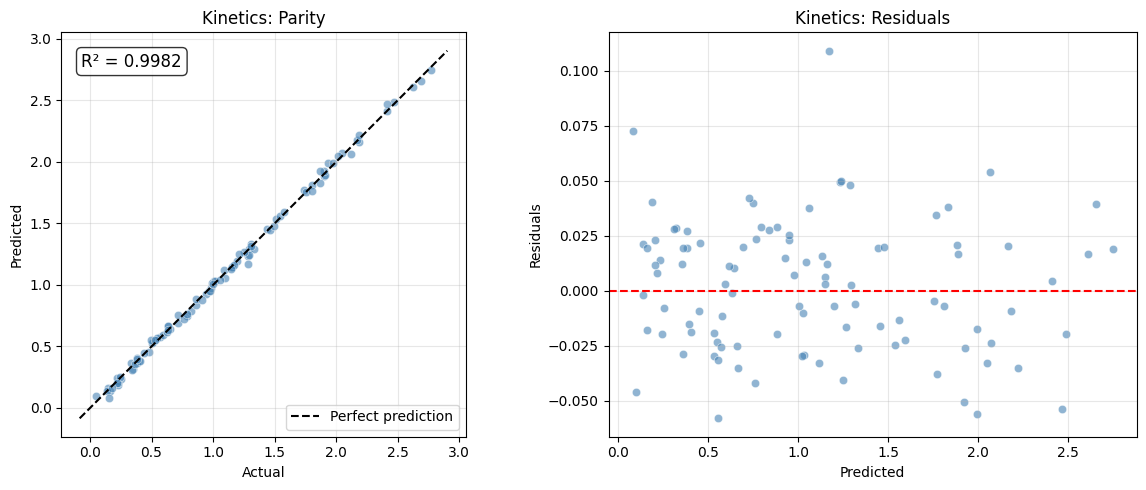

In [34]:
# Parameter significance and diagnostics for kinetics fit
intervals = model.coefficient_intervals(alpha=0.05)
n_obs, k_terms = len(np.asarray(y)), len(model.selected_features_)
df_resid = n_obs - k_terms

print("Parameter Significance (Kinetics Fit):")
print(f"  {'Term':>25s} {'Estimate':>10s} {'Std Err':>9s} {'t':>8s} {'p-value':>10s} 95% CI")
print("  " + "-" * 85)
for name, (est, lo, hi, se) in intervals.items():
    t_val = est / se if abs(se) > 1e-15 else float("inf")
    p_val = float(2 * (1 - sp_stats.t.cdf(abs(t_val), df_resid))) if df_resid > 0 else 0.0
    sig = "***" if p_val < 0.001 else ("**" if p_val < 0.01 else ("*" if p_val < 0.05 else ""))
    print(f"  {name:>25s} {est:10.4f} {se:9.4f} {t_val:8.2f} {p_val:10.2e} [{lo:.4f}, {hi:.4f}] {sig}")
print("  --- *** p<0.001, ** p<0.01, * p<0.05")

# Parity and residual plots
y_pred = model.predict(X)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_parity(y, y_pred, ax=axes[0], title="Kinetics: Parity")
residuals = np.array(y - y_pred)
axes[1].scatter(np.array(y_pred), residuals, alpha=0.6, c="steelblue", edgecolors="white", linewidth=0.5)
axes[1].axhline(y=0, color="r", linestyle="--")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Kinetics: Residuals")
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 11. Advanced: Heat Transfer Correlations

Discover empirical correlations like Dittus-Boelter.

In [35]:
# ANOVA table for heat transfer fit
anova_result = anova(model)
summary_sources = {"Model", "Residual", "Total"}

print("ANOVA Table (Heat Transfer - Dittus-Boelter)")
print("=" * 80)
print(f"  {'Source':25s}  {'DF':>4}  {'Sum Sq':>12}  {'Mean Sq':>12}  {'F':>10}  {'p-value':>10}")
print("-" * 80)
for row in anova_result.rows:
    f_str = f"{row.f_value:10.2f}" if row.f_value is not None else "          "
    p_str = f"{row.p_value:10.4f}" if row.p_value is not None else "          "
    print(f"  {row.source:25s}  {row.df:4d}  {row.sum_sq:12.4f}  {row.mean_sq:12.4f}  {f_str}  {p_str}")
print("-" * 80)

term_rows = [r for r in anova_result.rows if r.source not in summary_sources]
if term_rows:
    model_ss = sum(r.sum_sq for r in term_rows)
    print("\nVariance Contributions:")
    for row in term_rows:
        pct = 100 * row.sum_sq / model_ss if model_ss > 0 else 0
        sig = (
            "***" if row.p_value is not None and row.p_value < 0.001 else (
            "**" if row.p_value is not None and row.p_value < 0.01 else (
            "*" if row.p_value is not None and row.p_value < 0.05 else ""))
        )
        print(f"  {row.source:25s}  {pct:6.1f}%  {sig}")

ANOVA Table (Heat Transfer - Dittus-Boelter)
  Source                       DF        Sum Sq       Mean Sq           F     p-value
--------------------------------------------------------------------------------
  C_A*C_B/(1+C_A)               1       47.8515       47.8515    52409.79      0.0000
  C_A*C_B                       1        0.0952        0.0952      104.28      0.0000
  C_A*C_B/(1+C_A+C_B)           1        0.0047        0.0047        5.16      0.0253
  Model                         2       47.9514       23.9757    26259.62      0.0000
  Residual                     97        0.0886        0.0009                        
  Total                        99       48.0399        0.4853                        
--------------------------------------------------------------------------------

Variance Contributions:
  C_A*C_B/(1+C_A)              99.8%  ***
  C_A*C_B                       0.2%  ***
  C_A*C_B/(1+C_A+C_B)           0.0%  *


In [36]:
# Generate Dittus-Boelter correlation data
# True: Nu = 0.023 * Re^0.8 * Pr^0.4

np.random.seed(42)
n_samples = 100

Re = np.random.uniform(10000, 100000, n_samples)
Pr = np.random.uniform(0.7, 100, n_samples)

Nu_true = 0.023 * Re**0.8 * Pr**0.4
Nu = Nu_true * (1 + np.random.randn(n_samples) * 0.03)

# Work in log space
log_Re = np.log(Re)
log_Pr = np.log(Pr)
log_Nu = np.log(Nu)

X = jnp.column_stack([log_Re, log_Pr])
y = jnp.array(log_Nu)

print("True: Nu = 0.023 * Re^0.8 * Pr^0.4")
print(f"Log form: ln(Nu) = {np.log(0.023):.3f} + 0.8*ln(Re) + 0.4*ln(Pr)")

True: Nu = 0.023 * Re^0.8 * Pr^0.4
Log form: ln(Nu) = -3.772 + 0.8*ln(Re) + 0.4*ln(Pr)


## 12. Uncertainty Quantification

JAXSR provides comprehensive UQ capabilities. Since models are linear-in-parameters (`y = Phi @ beta`), classical OLS inference applies directly. JAXSR also supports distribution-free methods (conformal prediction, bootstrap) that make no Gaussian assumption.

We demonstrate with a simple true model:

$$y = 2x + 1 + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, 0.5^2)$$

### Available methods:
| Method | Assumption | What it provides |
|--------|-----------|-----------------|
| Classical OLS | Gaussian iid errors | Coefficient CIs, prediction/confidence bands |
| Pareto ensemble | Multiple models | Model uncertainty spread |
| Bayesian Model Averaging | IC approximation | Weighted prediction with between-model variance |
| Conformal (jackknife+, split) | Exchangeability | Distribution-free coverage guarantee |
| Residual bootstrap | iid residuals | Non-parametric coefficient/prediction CIs |

Parameter Significance (Heat Transfer - Dittus-Boelter):
             Term   Estimate   Std Err        t    p-value 95% CI
  ---------------------------------------------------------------------------
  C_A*C_B/(1+C_A)     2.5815    0.0353    73.11   0.00e+00 [2.5114, 2.6515] ***
          C_A*C_B    -0.0940    0.0143    -6.55   2.72e-09 [-0.1224, -0.0655] ***
  C_A*C_B/(1+C_A+C_B)    -0.1658    0.0730    -2.27   2.53e-02 [-0.3106, -0.0210] *
  --- *** p<0.001, ** p<0.01, * p<0.05


/var/folders/gq/k1kgbl7n539_4dl1md8x3jt80000gn/T/ipykernel_61762/2017247997.py:2: UserWarning: Constraints are active. Classical OLS intervals may not be valid. Consider using bootstrap methods instead.
  intervals = model.coefficient_intervals(alpha=0.05)


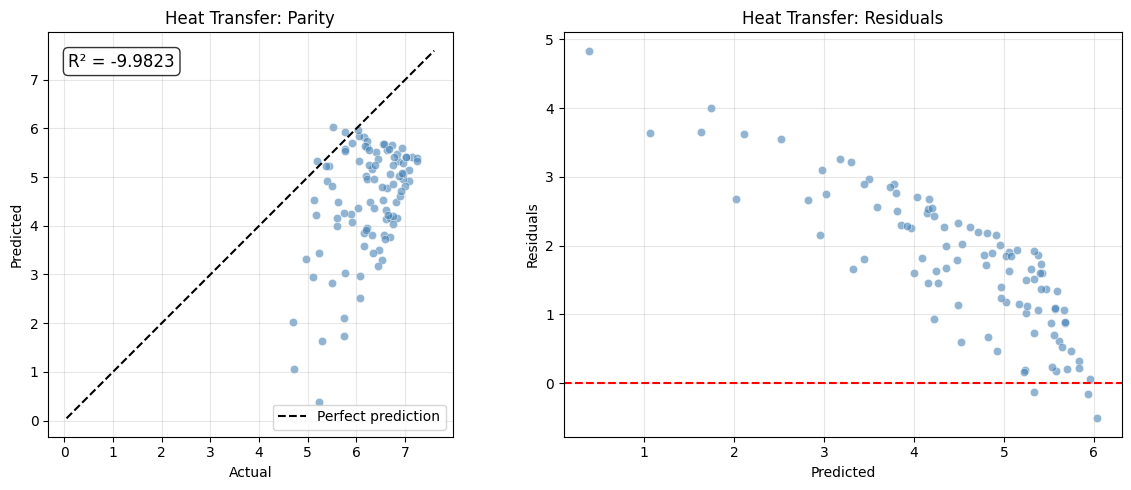

In [37]:
# Parameter significance for heat transfer fit
intervals = model.coefficient_intervals(alpha=0.05)
n_obs, k_terms = len(np.asarray(y)), len(model.selected_features_)
df_resid = n_obs - k_terms

print("Parameter Significance (Heat Transfer - Dittus-Boelter):")
print(f"  {'Term':>15s} {'Estimate':>10s} {'Std Err':>9s} {'t':>8s} {'p-value':>10s} 95% CI")
print("  " + "-" * 75)
for name, (est, lo, hi, se) in intervals.items():
    t_val = est / se if abs(se) > 1e-15 else float("inf")
    p_val = float(2 * (1 - sp_stats.t.cdf(abs(t_val), df_resid))) if df_resid > 0 else 0.0
    sig = "***" if p_val < 0.001 else ("**" if p_val < 0.01 else ("*" if p_val < 0.05 else ""))
    print(f"  {name:>15s} {est:10.4f} {se:9.4f} {t_val:8.2f} {p_val:10.2e} [{lo:.4f}, {hi:.4f}] {sig}")
print("  --- *** p<0.001, ** p<0.01, * p<0.05")

# Parity and residual plots
y_pred = model.predict(X)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_parity(y, y_pred, ax=axes[0], title="Heat Transfer: Parity")
residuals = np.array(y - y_pred)
axes[1].scatter(np.array(y_pred), residuals, alpha=0.6, c="steelblue", edgecolors="white", linewidth=0.5)
axes[1].axhline(y=0, color="r", linestyle="--")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Heat Transfer: Residuals")
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [38]:
# Extract and interpret coefficients
print("\nExtracted parameters:")
for name, coef in zip(model.selected_features_, model.coefficients_, strict=False):
    print(f"  {name}: {float(coef):.4f}")

# Recover original form
if "1" in model.selected_features_:
    idx = model.selected_features_.index("1")
    ln_C = float(model.coefficients_[idx])
    C = np.exp(ln_C)
    print(f"\nRecovered C = {C:.4f} (true: 0.023)")

if "ln_Re" in model.selected_features_:
    idx = model.selected_features_.index("ln_Re")
    m = float(model.coefficients_[idx])
    print(f"Recovered Re exponent = {m:.2f} (true: 0.80)")

if "ln_Pr" in model.selected_features_:
    idx = model.selected_features_.index("ln_Pr")
    n = float(model.coefficients_[idx])
    print(f"Recovered Pr exponent = {n:.2f} (true: 0.40)")


Extracted parameters:
  C_A*C_B/(1+C_A): 2.5815
  C_A*C_B: -0.0940
  C_A*C_B/(1+C_A+C_B): -0.1658


## Summary (Sections 1-11)

Sections 1-11 covered:

1. **Basic usage** - Fitting models and interpreting results
2. **Basis libraries** - Building custom function libraries (polynomials, transcendentals, ratios, compositions)
3. **Selection strategies** - Greedy forward, exhaustive search, LASSO path
4. **Regularization** - L2 (ridge) regularization to control overfitting
5. **Physical constraints** - Bounds, monotonicity, coefficient signs, fixed coefficients
6. **Custom constraints** - Arbitrary nonlinear constraints via callback functions
7. **Adaptive sampling** - Iterative model improvement with suggested experiments
8. **Model export** - SymPy, LaTeX, NumPy callable, save/load
9. **Applications** - Chemical kinetics and heat transfer correlations

Continue to Section 12 for Uncertainty Quantification.

## 12. Uncertainty Quantification

JAXSR provides comprehensive UQ capabilities. Since models are linear-in-parameters (`y = Phi @ beta`), classical OLS inference applies directly. JAXSR also supports distribution-free methods (conformal prediction, bootstrap) that make no Gaussian assumption.

### Available methods:
| Method | Assumption | What it provides |
|--------|-----------|-----------------|
| Classical OLS | Gaussian iid errors | Coefficient CIs, prediction/confidence bands |
| Pareto ensemble | Multiple models | Model uncertainty spread |
| Bayesian Model Averaging | IC approximation | Weighted prediction with between-model variance |
| Conformal (jackknife+, split) | Exchangeability | Distribution-free coverage guarantee |
| Residual bootstrap | iid residuals | Non-parametric coefficient/prediction CIs |

In [39]:
# Setup: Generate data with known model and noise level
np.random.seed(42)
n = 150
X_uq = np.random.uniform(0, 5, (n, 1))
y_true_uq = 2.0 * X_uq[:, 0] + 1.0
y_uq = y_true_uq + np.random.randn(n) * 0.5  # Known noise std = 0.5

X_uq_jax = jnp.array(X_uq)
y_uq_jax = jnp.array(y_uq)

# Fit model
library_uq = (BasisLibrary(n_features=1, feature_names=["x"])
    .add_constant()
    .add_linear()
    .add_polynomials(max_degree=3)
)

model_uq = SymbolicRegressor(
    basis_library=library_uq,
    max_terms=3,
    strategy="greedy_forward",
)
model_uq.fit(X_uq_jax, y_uq_jax)

print("True model: y = 2*x + 1  (noise std = 0.5)")
print(f"Discovered: {model_uq.expression_}")
print(f"R² = {model_uq.score(X_uq_jax, y_uq_jax):.4f}")

True model: y = 2*x + 1  (noise std = 0.5)
Discovered: y = 2.017*x + 0.9821
R² = 0.9712


In [40]:
# Noise estimate
print(f"Estimated noise std (sigma): {model_uq.sigma_:.4f}  (true: 0.5)")

# Coefficient confidence intervals
print("\n95% Coefficient Confidence Intervals:")
intervals = model_uq.coefficient_intervals(alpha=0.05)
for name, (est, lo, hi, se) in intervals.items():
    print(f"  {name}: {est:.4f}  [{lo:.4f}, {hi:.4f}]  (SE={se:.4f})")

# Covariance matrix
print("\nCoefficient covariance matrix:")
print(f"  {np.array(model_uq.covariance_matrix_)}")

Estimated noise std (sigma): 0.5170  (true: 0.5)

95% Coefficient Confidence Intervals:


  x: 2.0175  [1.9610, 2.0739]  (SE=0.0286)
  1: 0.9821  [0.8247, 1.1395]  (SE=0.0797)

Coefficient covariance matrix:
  [[ 0.00081609 -0.0019296 ]
 [-0.0019296   0.00634443]]


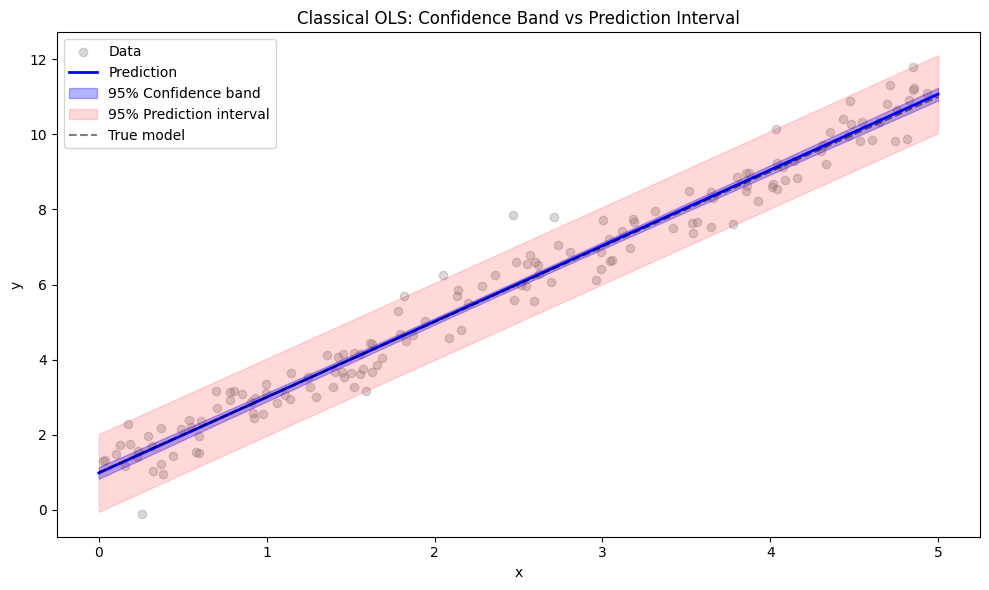

Note: Confidence band (blue) estimates E[y|x] — narrower.
      Prediction interval (red) covers a new observation — wider.


In [41]:
# Prediction intervals vs confidence bands
X_plot = jnp.linspace(0, 5, 100).reshape(-1, 1)

y_pred, pred_lo, pred_hi = model_uq.predict_interval(X_plot, alpha=0.05)
y_pred_c, conf_lo, conf_hi = model_uq.confidence_band(X_plot, alpha=0.05)

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(X_uq[:, 0], y_uq, alpha=0.3, label="Data", color="gray")
ax.plot(X_plot[:, 0], y_pred, "b-", linewidth=2, label="Prediction")
ax.fill_between(X_plot[:, 0], conf_lo, conf_hi, alpha=0.3, color="blue", label="95% Confidence band")
ax.fill_between(X_plot[:, 0], pred_lo, pred_hi, alpha=0.15, color="red", label="95% Prediction interval")
ax.plot(X_plot[:, 0], 2.0 * np.array(X_plot[:, 0]) + 1.0, "k--", alpha=0.5, label="True model")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Classical OLS: Confidence Band vs Prediction Interval")
ax.legend()
plt.tight_layout()
plt.show()

print("Note: Confidence band (blue) estimates E[y|x] — narrower.")
print("      Prediction interval (red) covers a new observation — wider.")

### 12.2 Pareto Front Ensemble

The Pareto front contains models at different complexity levels. Ensemble predictions show how much predictions vary across plausible model structures — a measure of **model/structural uncertainty**.

In [42]:
# Show Pareto front models
print("Pareto front models:")
for r in model_uq.pareto_front_:
    print(f"  Complexity {r.complexity}: {r.expression()}")

# Ensemble predictions
X_new = jnp.linspace(0, 5, 50).reshape(-1, 1)
result = model_uq.predict_ensemble(X_new)

print("\nEnsemble prediction statistics at selected points:")
print(f"  {'x':>5}  {'mean':>8}  {'std':>8}  {'min':>8}  {'max':>8}")
for i in range(0, 50, 10):
    print(
        f"  {float(X_new[i, 0]):5.1f}  "
        f"{float(result['y_mean'][i]):8.3f}  "
        f"{float(result['y_std'][i]):8.3f}  "
        f"{float(result['y_min'][i]):8.3f}  "
        f"{float(result['y_max'][i]):8.3f}"
    )

Pareto front models:
  Complexity 1: y = 2.017*x + 0.9821

Ensemble prediction statistics at selected points:
      x      mean       std       min       max


    0.0     0.982     0.000     0.982     0.982
    1.0     3.041     0.000     3.041     3.041
    2.0     5.099     0.000     5.099     5.099
    3.1     7.158     0.000     7.158     7.158
    4.1     9.217     0.000     9.217     9.217


### 12.3 Bayesian Model Averaging (BMA)

BMA weights models by their information criterion: `w_k = exp(-0.5 * delta_IC_k) / Z`. The BMA variance includes both **within-model** variance (noise) and **between-model** variance (model uncertainty).

In [43]:
from jaxsr import BayesianModelAverage

# Create BMA from fitted model
bma = BayesianModelAverage(model_uq, criterion="bic")

print("BMA model weights (BIC-based):")
for expr, weight in bma.weights.items():
    print(f"  {weight:.4f}  {expr}")

# BMA predictions with intervals
y_bma, bma_lo, bma_hi = model_uq.predict_bma(X_plot, criterion="bic", alpha=0.05)

print("\nBMA predictions at selected points:")
print(f"  {'x':>5}  {'pred':>8}  {'lower':>8}  {'upper':>8}")
for i in range(0, 100, 20):
    print(
        f"  {float(X_plot[i, 0]):5.1f}  "
        f"{float(y_bma[i]):8.3f}  "
        f"{float(bma_lo[i]):8.3f}  "
        f"{float(bma_hi[i]):8.3f}"
    )

BMA model weights (BIC-based):
  1.0000  y = 2.017*x + 0.9821



BMA predictions at selected points:
      x      pred     lower     upper
    0.0     0.982    -0.024     1.989
    1.0     3.020     2.013     4.026
    2.0     5.058     4.051     6.064
    3.0     7.096     6.089     8.102
    4.0     9.134     8.127    10.140


### 12.4 Conformal Prediction

Distribution-free prediction intervals with finite-sample coverage guarantees. No Gaussian assumption needed.

- **Jackknife+**: Uses LOO residuals from training data (no separate calibration set)
- **Split conformal**: Uses a held-out calibration set

In [44]:
# Jackknife+ conformal prediction (uses training data, no calibration set needed)
X_test_uq = jnp.linspace(0, 5, 50).reshape(-1, 1)
y_test_true = 2.0 * np.array(X_test_uq[:, 0]) + 1.0 + np.random.randn(50) * 0.5

y_conf, conf_lo, conf_hi = model_uq.predict_conformal(
    X_test_uq, alpha=0.10, method="jackknife+"
)

# Check coverage
covered = (y_test_true >= np.array(conf_lo)) & (y_test_true <= np.array(conf_hi))
coverage = np.mean(covered)

print("Jackknife+ conformal prediction (target: 90% coverage):")
print(f"  Actual coverage: {coverage:.1%}")
print(f"  Avg interval width: {float(jnp.mean(conf_hi - conf_lo)):.3f}")

# Split conformal (using held-out calibration data)
X_cal = jnp.array(X_uq[100:])  # Last 50 points as calibration
y_cal = jnp.array(y_uq[100:])

y_conf_s, conf_lo_s, conf_hi_s = model_uq.predict_conformal(
    X_test_uq, alpha=0.10, method="split", X_cal=X_cal, y_cal=y_cal
)

covered_s = (y_test_true >= np.array(conf_lo_s)) & (y_test_true <= np.array(conf_hi_s))
print("\nSplit conformal (target: 90% coverage):")
print(f"  Actual coverage: {np.mean(covered_s):.1%}")
print(f"  Avg interval width: {float(jnp.mean(conf_hi_s - conf_lo_s)):.3f}")

Jackknife+ conformal prediction (target: 90% coverage):
  Actual coverage: 94.0%
  Avg interval width: 1.630

Split conformal (target: 90% coverage):
  Actual coverage: 98.0%
  Avg interval width: 2.037


### 12.5 Residual Bootstrap

The residual bootstrap makes no Gaussian assumption. It resamples residuals (`y* = y_hat + e*`) and refits OLS for each bootstrap sample, giving empirical distributions of coefficients and predictions.

In [45]:
from jaxsr import bootstrap_coefficients, bootstrap_predict

# Bootstrap coefficient CIs
boot_result = bootstrap_coefficients(model_uq, n_bootstrap=2000, alpha=0.05, seed=42)

print("Bootstrap 95% coefficient CIs (B=2000):")
for i, name in enumerate(boot_result["names"]):
    print(
        f"  {name}: {float(boot_result['mean'][i]):.4f} "
        f"[{float(boot_result['lower'][i]):.4f}, {float(boot_result['upper'][i]):.4f}]  "
        f"(std={float(boot_result['std'][i]):.4f})"
    )

# Bootstrap prediction intervals
X_pred = jnp.array([[1.0], [2.5], [4.0]])
boot_pred = bootstrap_predict(model_uq, X_pred, n_bootstrap=2000, alpha=0.05, seed=42)

print("\nBootstrap 95% prediction intervals:")
print(f"  {'x':>5}  {'pred':>8}  {'lower':>8}  {'upper':>8}")
for i in range(len(X_pred)):
    print(
        f"  {float(X_pred[i, 0]):5.1f}  "
        f"{float(boot_pred['y_pred'][i]):8.3f}  "
        f"{float(boot_pred['lower'][i]):8.3f}  "
        f"{float(boot_pred['upper'][i]):8.3f}"
    )

Bootstrap 95% coefficient CIs (B=2000):
  x: 2.0177 [1.9616, 2.0700]  (std=0.0276)
  1: 0.9808 [0.8369, 1.1400]  (std=0.0791)



Bootstrap 95% prediction intervals:
      x      pred     lower     upper
    1.0     3.000     2.891     3.120
    2.5     6.026     5.943     6.112
    4.0     9.052     8.935     9.166


### 12.6 UQ Visualization

JAXSR provides built-in plotting functions for UQ: fan charts, coefficient forest plots, and BMA weight charts.

In [ ]:
from jaxsr.plotting import (
    plot_bma_weights,
    plot_coefficient_intervals,
    plot_prediction_intervals,
)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Fan chart: prediction intervals (bands from smooth X_plot, data overlaid at actual X_uq)
plot_prediction_intervals(model_uq, X_plot, alpha=0.05, ax=axes[0])
axes[0].scatter(
    np.array(X_uq[:, 0]),
    np.array(y_uq),
    c="black",
    s=20,
    alpha=0.6,
    zorder=5,
    label="Observed",
)
axes[0].legend()
axes[0].set_title("Prediction Intervals Fan Chart")

# Forest plot: coefficient CIs
plot_coefficient_intervals(model_uq, ax=axes[1])
axes[1].set_title("Coefficient Confidence Intervals")

# BMA weights
plot_bma_weights(model_uq, ax=axes[2])
axes[2].set_title("BMA Model Weights (BIC)")

plt.tight_layout()
plt.show()

### 12.7 Comparing UQ Methods

Different methods answer different questions. Here's a side-by-side comparison on the same data.

In [47]:
# Compare all UQ methods at specific test points
X_compare = jnp.array([[0.5], [2.5], [4.5]])

# Classical OLS
_, ols_lo, ols_hi = model_uq.predict_interval(X_compare, alpha=0.05)

# BMA
bma_pred, bma_lo, bma_hi = model_uq.predict_bma(X_compare, criterion="bic", alpha=0.05)

# Conformal (jackknife+)
_, conf_lo, conf_hi = model_uq.predict_conformal(X_compare, alpha=0.05, method="jackknife+")

# Bootstrap
boot_result = bootstrap_predict(model_uq, X_compare, n_bootstrap=2000, alpha=0.05, seed=42)

print("Comparison of 95% prediction intervals at x = 0.5, 2.5, 4.5:")
print("=" * 70)
for i, x_val in enumerate([0.5, 2.5, 4.5]):
    print(f"\nx = {x_val}  (true y = {2*x_val + 1:.1f})")
    print(f"  {'Method':<20} {'Lower':>8} {'Upper':>8} {'Width':>8}")
    print(f"  {'-'*20} {'-'*8} {'-'*8} {'-'*8}")

    methods = [
        ("OLS (classical)", float(ols_lo[i]), float(ols_hi[i])),
        ("BMA", float(bma_lo[i]), float(bma_hi[i])),
        ("Conformal (J+)", float(conf_lo[i]), float(conf_hi[i])),
        ("Bootstrap", float(boot_result['lower'][i]), float(boot_result['upper'][i])),
    ]
    for name, lo, hi in methods:
        print(f"  {name:<20} {lo:8.3f} {hi:8.3f} {hi-lo:8.3f}")

Comparison of 95% prediction intervals at x = 0.5, 2.5, 4.5:

x = 0.5  (true y = 2.0)
  Method                  Lower    Upper    Width
  -------------------- -------- -------- --------
  OLS (classical)         0.960    3.021    2.061
  BMA                     0.984    2.997    2.013
  Conformal (J+)          0.955    3.027    2.072
  Bootstrap               1.862    2.128    0.266

x = 2.5  (true y = 6.0)
  Method                  Lower    Upper    Width
  -------------------- -------- -------- --------
  OLS (classical)         5.001    7.051    2.050
  BMA                     5.019    7.032    2.013
  Conformal (J+)          4.990    7.062    2.072
  Bootstrap               5.943    6.112    0.169

x = 4.5  (true y = 10.0)
  Method                  Lower    Upper    Width
  -------------------- -------- -------- --------
  OLS (classical)         9.029   11.093    2.064
  BMA                     9.054   11.067    2.013
  Conformal (J+)          9.025   11.097    2.072
  Bootstrap  

### Choosing a UQ Method

| When to use | Method |
|-------------|--------|
| Standard case, Gaussian errors | Classical OLS intervals |
| Unknown error distribution | Conformal prediction or bootstrap |
| Multiple plausible models | Pareto ensemble or BMA |
| Need coverage guarantees | Conformal prediction |
| Want coefficient distributions | Bootstrap |
| Constrained/regularized model | Bootstrap (classical OLS may be invalid) |

**Note**: When constraints or regularization are active, JAXSR warns that classical OLS intervals may not be valid. Use bootstrap or conformal methods instead.